In [4]:
import numpy as np
import matplotlib.pyplot as plt

## Trading in V3
In this note, we discuss the idea of trading behind Uniswap V3. Given $S^* \in I_i$ and $\bar{S}^* \in I_k$ with
$l \leq k$ and $0 < S^* \leq \bar{S}^*$, we use the notations $(x_i,y_i)=R_3(I_i,L_i,S^*)$, $(x_k,y_k)=R_3(I_i,L_i,\bar{S}^*)$, $(0,y^*_j) = R_3(I_j,L_j,P_{j})$, $(x^*_j,0) = R_3(I_j,L_j,P_{j+1})$ for
$i\leq j\leq k$ and define the following quantities:
- **Amount of $Y$ reserves** between 
    $S^*$ and $\bar{S}^*$: $r_Y(S^* , \bar{S}^*) \equiv y_i+\sum^{k-1}_{j=i+1}y^*_j +y^*_k - y_k$
- **Amount of $X$ reserves** between
     $S^*$ and $\bar{S}^*$: $r_X(S^*, \bar{S}^*) \equiv x_k+ \sum^{k-1}_{j=i+1}x^*_j+ x^*_i-x_i $

The summation vanishes if $k=i$. One can write the liquidity as a step function of the pool price:
- $$L(S^*) \equiv \sum^\infty_{i=0} L_i I_{[P_i,P_{i+1}\;]}(S^*)$$
Then when $S^* \in [P_i , P_{i+1}]$, the reserves on that tick can be expressed as integrals:
- $$ x_i = L_i( \sqrt{S^*} - \sqrt{P}_i) = \int_{P_i}^{S^*} \frac{1}{2} L(t)t^{\frac{3}{2}} dt$$
- $$ y_i = L_i( \frac{1}{\sqrt{S^*}} - \frac{1}{\sqrt{P}_{i+1})} 
= \int_{S^*}^{P_{i+1}} \frac{1}{2} L(t)t^{-\frac{3}{2}} dt$$
Same for the quantities we defined above:
- $$r_X(S^* , \bar{S}^*) = \int_{S^*}^{\bar{S}^*} \frac{1}{2} L(t)t^{\frac{3}{2}} dt$$
- $$r_Y(S^* , \bar{S}^*) = \int_{S^*}^{\bar{S}^*} \frac{1}{2} L(t)t^{-\frac{3}{2}} dt$$

Buying $\Delta y >0$ amount of asset $Y$ from the pool can be considered as  a mapping that maps the current pool price $S^*$ to the new pool price $\bar{S^*}$ that is given by:
$$
\bar{S^*} \equiv \inf\{s^*>S^* \mid r_Y(S^*,s^*)= \Delta y \wedge y_{max}\}
=\begin{cases}
    P_{n_{max}}  & \text{if} \; \Delta y \geq y_{max}
    \\
    \inf\{s^*>S^* \mid r_Y(S^*,s^*)= \Delta y\} 
    & \text{if} \; \Delta y < y_{max}
\end{cases} 
$$
where $y_{max} = r_Y(S^*,P_{n_{max}\;})$ is the current total amount of $Y$ reserves in the pool and $[P_{n_{max}\;\,-1} ,P_{n_{max}\;}]$ is the right most tick that has nozero liquidity. Similary, selling $\Delta y >0$ amount of asset $Y$ to the pool
pushes the the pool price to $\bar{S}^*$ given by:
$$
\bar{S^*} \equiv 
\sup\{s^*< \bar{S}^* \mid r_Y(s^*,\bar{S}^*)=\gamma\Delta y \wedge \bar{y}_{max}\}
=\begin{cases}
    P_{n_{min}}  
    & \text{if} \;  \gamma\Delta y \geq \bar{y}_{max}
    \\
    \sup\{s^*<\bar{S}^* \mid r_Y(s^*,\bar{S}^*)\geq \gamma\Delta y\} 
    & \text{if} \; \gamma\Delta y=\bar{y}_{max}
\end{cases} 
$$
where $\gamma>0$ is the fee constant.

### Code

Parameters:
- ```S_pool```: The current pool price.
- ```ticks_array```: An array that consists of tick prices $\{P_i\}_{i \geq 0}$ sepcifying all ticks $I_i = [P_i , P_{i+1}]$ that have liquidity. We expected it to be bounded away from zero.

Functions:
- ```activated_ticks_index```: Given the current pool price, return the index of the tick where it locates. When the pool price equals to one of the tick price, choose the larger index (e.g $S^* = P_i$ , returns $i$).

In [5]:
def activated_ticks_index(S_pool,ticks_array):
    left, right = 0, len(ticks_array) - 1
    while left <= right:
        mid = (right + left) // 2
        if mid == len(ticks_array) - 1:
            if S_pool ==ticks_array[mid]:
                return mid
            else: #S_pool outside of the given range
                break
        else:   
            if ticks_array[mid] <= S_pool < ticks_array[mid + 1]:
                return mid  
            elif S_pool < ticks_array[mid]:
                right = mid - 1
            else:
                left = mid + 1
    return -1  

Parameters:
- ```S_pool_0```: Lower pool price for computing $r_X$ and $r_Y$.
- ```S_pool_1```: Upper pool price for computing $r_X$ and $r_Y$.
- ```L_array```: An array that consists of the liquidity on each tick (corresponding to ```ticks_array```). 

Functions:
- ```r_X```: Compute the amount of $X$ reserves between two given prices.
- ```r_Y```: Compute the amount of $Y$ reserves between two given prices.

In [6]:
def r_X(S_pool_0 , S_pool_1 , L_array,ticks_array):
    if S_pool_0 > S_pool_1:
        print("error!first argument should be smaller than the second!")
    index_0= activated_ticks_index(S_pool_0,ticks_array)
    index_1= activated_ticks_index(S_pool_1,ticks_array)
    if index_0 ==-1 or index_1 ==-1:
        print("error!outside of tick range!")
        
    amount =0
    for i in range(index_0 ,index_1+1):
        if i == index_0:
            amount+=L_array[i]*(np.sqrt(ticks_array[i+1])-np.sqrt(S_pool_0) )
        elif i == index_1:
            amount+= L_array[i]*( np.sqrt(S_pool_1) - np.sqrt(ticks_array[i])  ) 
        else:
            amount+=L_array[i]*( np.sqrt(ticks_array[i+1]) - np.sqrt(ticks_array[i])  )
    return amount

def r_Y(S_pool_0 , S_pool_1,L_array,ticks_array):
    if S_pool_0 > S_pool_1:
        print("error!first argument should be smaller than the second!")

    index_0= activated_ticks_index(S_pool_0,ticks_array)
    index_1= activated_ticks_index(S_pool_1,ticks_array)
    if index_0 ==-1 or index_1 ==-1:
        print("error!outside of tick range!")
    amount =0
    for i in range(index_0 ,index_1+1):
        if i == index_0:
            amount += L_array[i]*( 1/np.sqrt(S_pool_0) - 1/np.sqrt(ticks_array[i+1]) )
        elif i == index_1:
            amount += L_array[i]*( 1/np.sqrt(ticks_array[i]) - 1/np.sqrt(S_pool_1)  )
        else:
            amount += L_array[i]*( 1/np.sqrt(ticks_array[i]) - 1/np.sqrt(ticks_array[i+1]) ) 
    return amount

Parameters:
- ```delta_y```: The amount of asset $Y$ the trader wants to sell/buy. When the input is positive, the trader sells $Y$ to the pool. And when it is negative, the trader buys $Y$ from the pool.
- ```gamma```: The fee constant $ \gamma \in (0,1) $. 
- ```S_pool_ini```: The initial pool price when the trade is conducted.

Functions:
- ```trade```: Return a tuple consists of the amount of asset $X$ the trader receives/pays from the trade and the pool price after trade.

In [7]:
def trade(delta_y,gamma,S_pool_ini,L_array,ticks_array):
    index_ini = activated_ticks_index(S_pool_ini,ticks_array)
    if delta_y>=0: #sell Y
        sell=gamma*delta_y
        i=index_ini 
        S_pool = S_pool_ini
        while sell > 0: #trade tick-by-tick
            if i <0:  #not enough capacity for Y paid by the trader, equivalently , not enough X to pay the trader
                S_pool_final = ticks_array[0]
                print("out of X reserves")
                break
            max_Y = r_Y(ticks_array[i], S_pool,L_array,ticks_array) #current max amount(capacity) of Y on the tick                
            if sell <= max_Y: #the trade finishes at this tick
                S_pool_fin=(1/np.sqrt(S_pool)+sell/L_array[i])**(-2)
                break
            else: 
                sell=sell-max_Y   #trader receives all X on that tick         
                S_pool = ticks_array[i] #pool price moves to the next tick
                i=i-1         
    return r_X(S_pool_fin,S_pool_ini,L_array,ticks_array) , S_pool_fin
    
    if delta_y<0: #buy y
        buy= -delta_y
        i=index_ini 
        S_pool = S_pool_ini
        while buy > 0: #trade tick-by-tick
            if i >=len(ticks_array)-1: #not enough Y to pay the trader
                S_pool_final = ticks_array[-1]
                print("out of Y reserves")
                break
            max_Y = r_Y(S_pool,ticks_array[i+1],L_array,ticks_array) #current max amount(reserve) of Y on the tick                
            if buy <= max_Y: 
                S_pool_fin=(1/np.sqrt(S_pool)- buy/L_array[i])**(-2)
                break
            else: 
                buy=buy-max_Y  #trader buys all Y on that tick
                S_pool = ticks_array[i+1]  
                i=i+1   
    return gamma*r_X(S_pool_ini,S_pool_fin,L_array,ticks_array) , S_pool_fin
    

### Examples


Let $I_i = [P_i , P_{i+1}] = [1.5^i , 1.5^{i+1}]$ for $i = -10 \sim 19$ and $L_i = e^{-(\ln{P_i}-1)^2}$. First we plot the liquidity
w.r.t the pool price.

In [26]:
A = np.arange(10)
[ 2*a if a>1 for a in A]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Text(0, 0.5, 'liquidity')

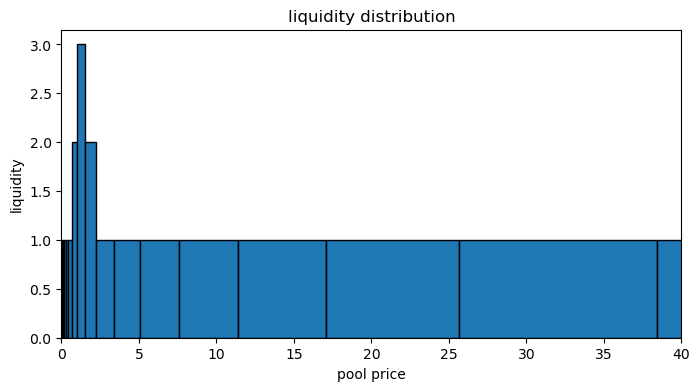

In [30]:
ticks_array=np.array([1.5**i for i in range(-10,20)])
index = activated_ticks_index(1,ticks_array)
L_array = np.ones_like(ticks_array) 
L_array[index] = 3
L_array[index-1] = 2
L_array[index+1] = 2
L_array[-1] = 0
plt.figure(figsize=(8,4))
plt.bar(ticks_array , L_array , width =np.append(np.diff(ticks_array),0),align='edge',ec='black')
plt.title("liquidity distribution")
plt.xlim(0,40)
plt.xlabel("pool price")
plt.ylabel("liquidity")

Next we plot the functions $r_X(S^*_0,\cdot)$ and $r_Y(S^*_0,\cdot)$ w.r.t the pool price.

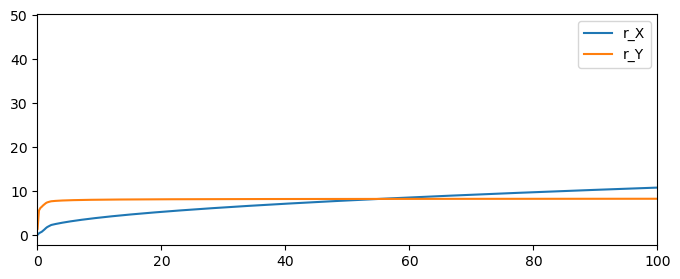

In [32]:
plt.figure(figsize=(8,3))

P_0 =ticks_array[0]
P_max = ticks_array[-1]
r_X_array = np.array([r_X(P_0 , s , L_array,ticks_array) for s in np.linspace(P_0,P_max,10**4)])
r_Y_array = np.array([r_Y(P_0 , s , L_array,ticks_array) for s in np.linspace(P_0,P_max,10**4)])
plt.plot(np.linspace(P_0,P_max,10**4),r_X_array,label="r_X")
plt.plot(np.linspace(P_0,P_max,10**4),r_Y_array,label="r_Y")
plt.xlim(0,100)
plt.legend()

From the above we note that $r_X(S^*_0,\cdot)$ and $r_Y(S^*_0,\cdot)$ can be expressed as the integral of some
density $$d_X(s^*) = \frac{1}{2}L(s^*)(s^*)^\frac{3}{2} \; , \; d_Y(s^*) = \frac{1}{2}L(s^*)(s^*)^{-\frac{3}{2}}$$

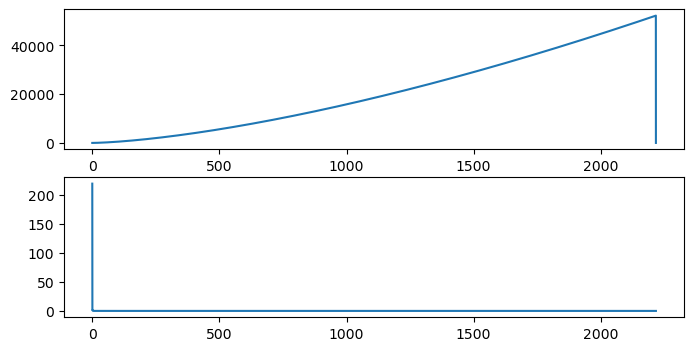

In [33]:
fig,ax =plt.subplots(2,1,figsize=(8,4))
d_X = np.array([1/2*L_array[activated_ticks_index(s,ticks_array)]*s**(3/2) for s in np.linspace(P_0,P_max,10**4)] )
d_Y = np.array([1/2*L_array[activated_ticks_index(s,ticks_array)]*s**(-3/2) for s in np.linspace(P_0,P_max,10**4)] )
ax[0].plot(np.linspace(P_0,P_max,10**4),d_X)
ax[1].plot(np.linspace(P_0,P_max,10**4),d_Y)
